In [ ]:
from google.colab import files
files.upload()
!ls -lha kaggle-3.json 
!pip install -q kaggle 
!mkdir -p ~/.kaggle 
!cp kaggle-3.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle-3.json to kaggle-3.json
-rw-r--r-- 1 root root 64 Feb  5 15:29 kaggle-3.json


In [ ]:
!kaggle datasets download macfooty/sudoku-box-detection
!unzip /content/sudoku-box-detection.zip

 99% 117M/118M [00:01<00:00, 97.6MB/s]
100% 118M/118M [00:01<00:00, 94.2MB/s]
Archive:  /content/sudoku-box-detection.zip
  inflating: aug/_0_1018787.jpeg     
  inflating: aug/_0_1436352.jpeg     
  inflating: aug/_0_1687235.jpeg     
  inflating: aug/_0_3815548.jpeg     
  inflating: aug/_0_6290258.jpeg     
  inflating: aug/_0_6580185.jpeg     
  inflating: aug/_0_7427031.jpeg     
  inflating: aug/_0_7670549.jpeg     
  inflating: aug/_0_7804667.jpeg     
  inflating: aug/_0_8213354.jpeg     
  inflating: aug/_0_8253634.jpeg     
  inflating: aug/_0_9108897.jpeg     
  inflating: aug/_0_9159144.jpeg     
  inflating: aug/_0_9170704.jpeg     
  inflating: aug/_0_926439.jpeg      
  inflating: aug/_0_9607135.jpeg     
  inflating: aug/_100_2605002.jpeg   
  inflating: aug/_100_269740.jpeg    
  inflating: aug/_100_2756839.jpeg   
  inflating: aug/_100_3394881.jpeg   
  inflating: aug/_100_3511539.jpeg   
  inflating: aug/_100_4270930.jpeg   
  inflating: aug/_100_5064037.jpeg   
  in

In [1]:
import cv2
import matplotlib.pyplot as plt

def preprocess(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # kernel sizes must be positive and odd and the kernel must be square.
    # gaussian blur used to mute/remove noise from images taken in different light settings
    process = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # adaptive tresholding is done as the images may have different lighting conditions, so thresholding of a pixel should be dependent on neighbouring pixels and not a flat threshold
    process = cv2.adaptiveThreshold(process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    process = cv2.bitwise_not(process, process)

    return process

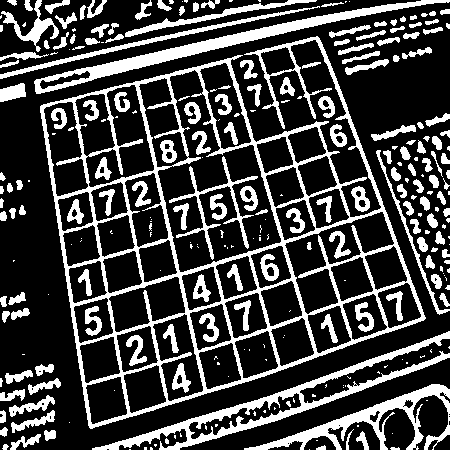

In [2]:
from google.colab.patches import cv2_imshow
img = cv2.imread("board.jpg")
img = cv2.resize(img, (450,450))
preprocessed_img = preprocess(img)

cv2_imshow(preprocessed_img)

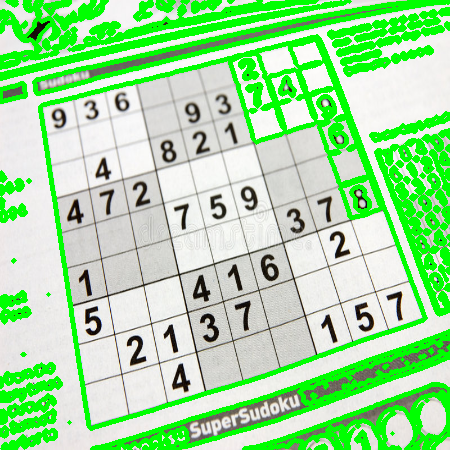

In [3]:
base_img = img.copy()
contour, hierarchy = cv2.findContours(preprocessed_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(base_img, contour,-1,(0,255,0),3)

cv2_imshow(base_img)

In [4]:
def find_corners(img):
    """ extracting contours within the image to find the board """
    # CHAIN_APPROX_SIMPLE - stores only minimal information of points to describe contour
    # -> RETR_EXTERNAL: gives "outer" contours to ignore smaller enclosed shapes
    ext_contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ext_contours = ext_contours[0] if len(ext_contours) == 2 else ext_contours[1]
    ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)

    # want to find the largest rectangular contour
    for c in ext_contours:
      peri = cv2.arcLength(c, True)
      approx = cv2.approxPolyDP(c, 0.015 * peri, True)
      # ensure the contour is made up of 4 points
      if len(approx) == 4:
          return approx


def order_corner_points(corners):
    """ reording corners in clockwise order """
    # Index 0 - top-right
    #       1 - top-left
    #       2 - bottom-left
    #       3 - bottom-right
    corners = [(corner[0][0], corner[0][1]) for corner in corners]
    top_r, top_l, bottom_l, bottom_r = corners[0], corners[1], corners[2], corners[3]
    return top_l, top_r, bottom_r, bottom_l

def perspective_transform(image, corners):
    """ transform image to get a full frontal view and remove any warping """

    # Order points in clockwise order
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners

    # Determine width of new image which is the max distance between
    # (bottom right and bottom left) or (top right and top left) x-coordinates
    width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
    width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
    width = max(int(width_A), int(width_B))

    # Determine height of new image which is the max distance between
    # (top right and bottom right) or (top left and bottom left) y-coordinates
    height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
    height = max(int(height_A), int(height_B))

    # Construct new points to obtain top-down view of image in
    # top_r, top_l, bottom_l, bottom_r order
    # Then calculate perspective transform matrix with the ordered corners and specified dimensions
    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1],
                           [0, height - 1]], dtype="float32")
    ordered_corners = np.array(ordered_corners, dtype="float32")
    matrix = cv2.getPerspectiveTransform(ordered_corners, dimensions)

    # apply the calculated matrix to the original image to get the warped image
    return cv2.warpPerspective(image, matrix, (width, height))


def create_image_grid(img):
    """ creates a 9x9 array with the corresponding cell images in the board """

    grid = np.copy(img)
    # not all sudoku out there have same width and height in the small squares so we need to consider differnt heights and width
    edge_h = np.shape(grid)[0]
    edge_w = np.shape(grid)[1]
    celledge_h = edge_h // 9
    celledge_w = np.shape(grid)[1] // 9

    grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding the cropped grid and inverting it
    grid = cv2.bitwise_not(grid, grid)

    tempgrid = []
    for i in range(celledge_h, edge_h + 1, celledge_h):
        for j in range(celledge_w, edge_w + 1, celledge_w):
            rows = grid[i - celledge_h:i]
            tempgrid.append([rows[k][j - celledge_w:j] for k in range(len(rows))])

    # Creating the 9X9 grid of images
    finalgrid = []
    for i in range(0, len(tempgrid) - 8, 9):
        finalgrid.append(tempgrid[i:i + 9])

    # Converting all the cell images to np.array
    for i in range(9):
        for j in range(9):
            finalgrid[i][j] = np.array(finalgrid[i][j])

    try:
        for i in range(9):
            for j in range(9):
                np.os.remove("BoardCells1/cell" + str(i) + str(j) + ".jpg")
    except:
        pass
    for i in range(9):
        for j in range(9):
            cv2.imwrite(str("BoardCells1/cell" + str(i) + str(j) + ".jpg"), finalgrid[i][j])

    return finalgrid


def scale_and_centre(img, size, margin=20, background=0):
    """ Scales and centres an image onto a new background square """
    h, w = img.shape[:2]

    def centre_pad(length):
        """ Handles centering for a given length that may be odd or even """
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))


def extract():
    """ Run processing pipeline to extract board """
    img = cv2.imread('/content/board.jpg')
    processed_sudoku = preprocess(img)
    sudoku = find_corners(processed_sudoku)
    transformed = perspective_transform(img, sudoku)
    # cropped = 'cropped_img.png'
    # cv2.imwrite(cropped, transformed)
    transformed = cv2.resize(transformed, (450, 450))
    cv2_imshow(transformed)
    sudoku = create_image_grid(transformed)
    return sudoku

In [5]:
import cv2
import numpy as np
from tensorflow.python.keras.models import load_model
import matplotlib.pyplot as plt

def display_image(img):
    cv2.imshow('image', img)
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 


def extract_digits(img_grid):
    """ processes each cell to obtain the digit contained in it and returns the fully extracted matrix """
    tmp_sudoku = [[0 for i in range(9)] for j in range(9)]
    for i in range(9):
        for j in range(9):

            image = img_grid[i][j]
            image = cv2.resize(image, (28, 28))
            original = image.copy()

            thresh = 128 
            gray = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]

            # Find contours
            cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = cnts[0] if len(cnts) == 2 else cnts[1]

            for c in cnts:
                x, y, w, h = cv2.boundingRect(c)

                if (x < 3 or y < 3 or h < 3 or w < 3):
                    # Note the number is always placed in the center
                    # Since image is 28x28
                    # the number will be in the center thus x >3 and y>3
                    # Additionally any of the external lines of the sudoku will not be thicker than 3
                    continue
                ROI = gray[y:y + h, x:x + w]
                ROI = scale_and_centre(ROI, 120)

                tmp_sudoku[i][j] = predict(ROI)

    return tmp_sudoku


def predict(img_grid):
    """ uses the model trained on digits to extract the digit within a cell """
    image = img_grid.copy()
    image = cv2.resize(image, (28, 28))

    image = image.astype('float32')
    image = image.reshape(1, 28, 28, 1)
    image /= 255

    model = load_model('/content/model_digit.h5')
    pred = model.predict(image.reshape(1, 28, 28, 1), batch_size=1)
    return pred.argmax()

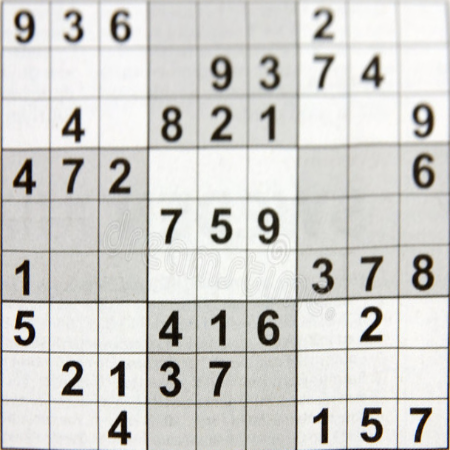

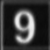

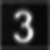

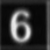

In [6]:
from google.colab.patches import cv2_imshow
image_grid = extract()

cv2_imshow(image_grid[0][0])
cv2_imshow(image_grid[0][1])
cv2_imshow(image_grid[0][2])

In [ ]:
board = extract_digits(image_grid)

for row in board:
  print (row)

[3, 3, 5, 0, 0, 0, 5, 0, 0]
[0, 0, 0, 0, 3, 3, 1, 6, 0]
[0, 6, 0, 3, 8, 7, 0, 0, 3]
[6, 1, 8, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 3, 3, 0, 0, 0]
[7, 0, 0, 0, 0, 0, 3, 1, 0]
[3, 0, 0, 6, 7, 6, 0, 8, 0]
[0, 8, 7, 3, 2, 0, 0, 0, 0]
[0, 0, 6, 0, 0, 0, 7, 3, 2]


In [ ]:
# From Tech with Tim tutorial
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False


def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True


def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")


def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col

    return None

print_board(board)
solve(board)
print("___________________")
print_board(board)